# Overview and Data
This project deals with classifying masses found in mammogram results as benign or malignant. The data is from the UCI repository. One can find the basic info for the columns below:

BI-RADS: 1 to 5 (ordinal) rating on confidence of severity classification  <br>
Age: (integer) <br>
Shape: round=1, oval=2, lobular=3, irregular=4 <br>
Margin: circumscribed=1, microlobulated=2, obscured=3, ill-defined=4, spiculated=5 <br>
Density: high=1, iso=2, low=3, fat-containing=4 <br>
Severity: benign=0, malignant=1
<br> <br>
The goal of this project is to test different classification methods and find which works best for this problem. The models that will be used are random forest, KNN, Naive Bayes, and logistic regression. Finding a model that can accurately classify the masses could have a huge impact by reducing the amount of patients taking the wrong steps moving due to false positives and false negatives.

## Loading and preparing data

The data is a text file where values are separated by a comma. Reading a csv will work.

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('mammographic_masses.data.txt', names = ['BI_RADS', 'age', 'shape', 'margin', 'density', 'severity'])
data.head(10)

,BI_RADS,age,shape,margin,density,severity
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1
5,4,65,1,?,3,0
6,4,70,?,?,3,0
7,5,42,1,?,3,0
8,5,57,1,5,3,1
9,5,60,?,5,1,1


Data is missing which is represented by question marks as values. The rows with missing values can be deleted as long as one column doesn't contain too much of the missing data that it is biased. Additionally, we can drop the BI_RADS column because its not really a predictor and is actually based off the observer's thoughts.

In [2]:
data.drop('BI_RADS', axis = 1, inplace = True)
print('The number of question marks by column is shown below:\n' + str((data == data['density'][1]).sum()))
print('\nThe data originally has ' + str(data.shape[0]) + ' rows.')


The number of question marks by column is shown below:
age          5
shape       31
margin      48
density     76
severity     0
dtype: int64

The data originally has 961 rows.


Compared to the size of the data, the number of missing values for each column doesn't seem to be too heavily favored in one area so the rows with missing values will be deleted.

In [3]:
data.drop(data[data.values == '?'].index, inplace = True)
data.head(10)

,age,shape,margin,density,severity
0,67,3,5,3,1
2,58,4,5,3,1
3,28,1,1,3,0
8,57,1,5,3,1
10,76,1,4,3,1
11,42,2,1,3,1
13,36,3,1,2,0
14,60,2,1,2,0
15,54,1,1,3,0
16,52,3,4,3,0


From below, the categorical data all fall in the values specified by the data so there does not seem to be an error there.

4    380
1    190
2    180
3     81
Name: shape, dtype: int64
1    320
4    255
5    127
3    106
2     23
Name: margin, dtype: int64
3    756
2     56
1     11
4      8
Name: density, dtype: int64
0    428
1    403
Name: severity, dtype: int64


Text(0.5,0,'Age')

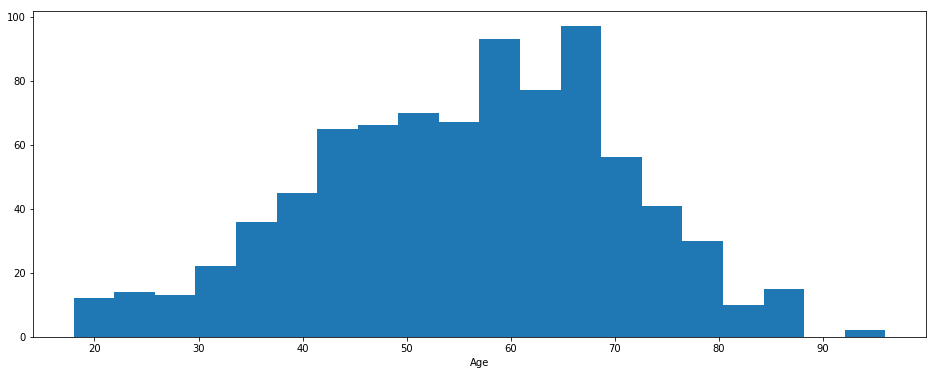

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

print(data['shape'].value_counts())
print(data['margin'].value_counts())
print(data['density'].value_counts())
print(data['severity'].value_counts())
data['age'] = data['age'].map(int)

plt.figure(figsize = (16,6))
plt.hist(data['age'].values, bins = 20)
plt.xlabel('Age')

Text(0,0.5,'Age')

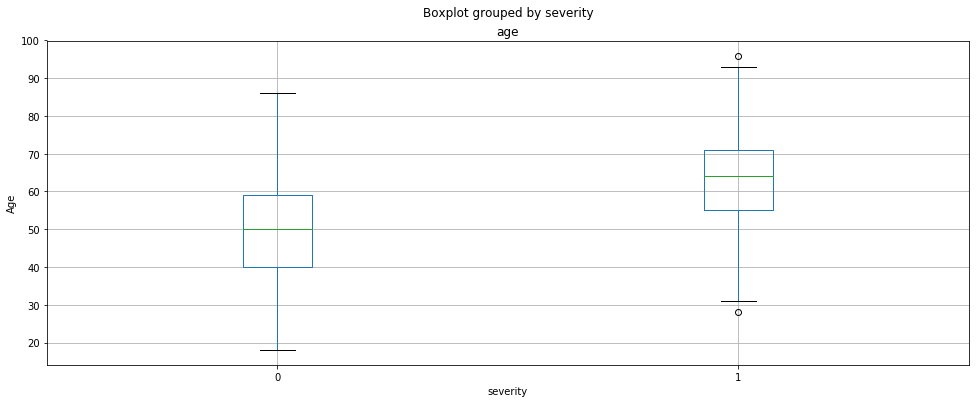

In [5]:
data.boxplot('age', by = 'severity', figsize = (16,6))
plt.ylabel('Age')

The boxplot and histogram show that there are a couple outliers for the age. However, the age outliers seem to be going with the general idea of the data so all points will be kept.
Next, the data will be scaled because some models like KNN will benefit from it.

In [6]:
from sklearn import preprocessing

features = data.iloc[:,:-1].values
classes = data.iloc[:,-1].values
scaler = preprocessing.StandardScaler()
normed = scaler.fit_transform(features)

D:\Python\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(normed, classes, train_size = 0.75, random_state = 1)

D:\Python\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 200)
rfc.fit(train_X, train_y)
rfc_predictions = rfc.predict(test_X)
rfc.score(test_X,test_y)

0.7403846153846154

## KNN


Text(0,0.5,'Accuracy of Model')

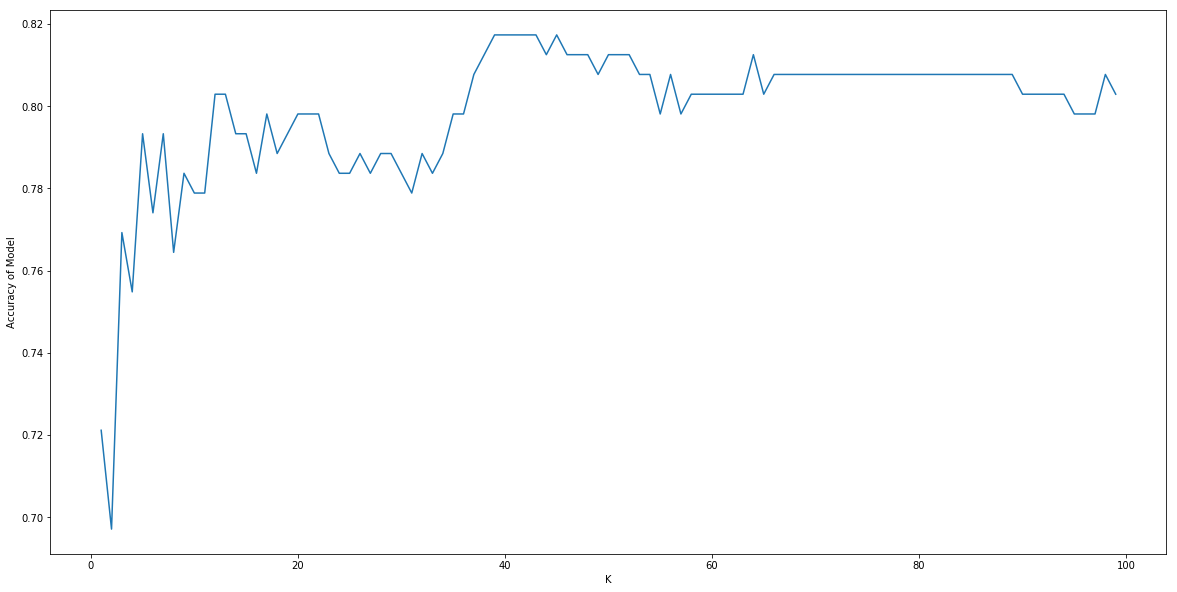

In [9]:
from sklearn import neighbors

knc_scores = []
for i in range(1,100):
    knc = neighbors.KNeighborsClassifier(n_neighbors = i)
    knc.fit(train_X, train_y)
    knc_scores.append(knc.score(test_X, test_y))

plt.figure(figsize=(20,10))
plt.plot(range(1,100), knc_scores)
plt.xlabel('K')
plt.ylabel('Accuracy of Model')

As we can see from the plot, the accuracy jumps up in the beginning as K increases. It then remains steady for awhile and has a small increase toward the end. I'll pick my K to be 12 which is after the initial jump. Although accuracy is shown to be a bit higher later, 'overfitting' can be a problem.

In [10]:
knc = neighbors.KNeighborsClassifier(12)
knc.fit(train_X, train_y)
knc_predictions = knc.predict(test_X)
knc.score(test_X, test_y)

0.8028846153846154

## Naive Bayes

For Naive Bayes, we will scale the data differently because it cannot take negative values.

In [11]:
from sklearn.naive_bayes import MultinomialNB

nbscaler = preprocessing.MinMaxScaler()
nbscaled = nbscaler.fit_transform(features)
nbtrain_X, nbtest_X, nbtrain_y, nbtest_y = train_test_split(nbscaled, classes, train_size = 0.75, random_state = 1)

nbc = MultinomialNB()
nbc.fit(nbtrain_X,nbtrain_y)
nbc_predictions = nbc.predict(test_X)
nbc.score(nbtest_X, nbtest_y)

D:\Python\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Python\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.7692307692307693

## Logistic Regression


In [12]:
from sklearn.linear_model import LogisticRegression

lrc = LogisticRegression()
lrc.fit(train_X, train_y)
lrc_predictions = lrc.predict(test_X)
lrc.score(test_X, test_y)

0.8221153846153846

# Classification Reports

In [13]:
from sklearn.metrics import classification_report

def print_report(ytest, ypredict, model_name):
    print('The classification report for ' + model_name + ' is shown below:\n')
    print(classification_report(ytest, ypredict) + '\n')

print_report(test_y, rfc_predictions, 'Random Forests')
print_report(test_y, knc_predictions, 'KNN')
print_report(nbtest_y, nbc_predictions, 'Naive Bayes')
print_report(test_y, lrc_predictions, 'Logistic Regression')

The classification report for Random Forests is shown below:

             precision    recall  f1-score   support

          0       0.75      0.76      0.75       108
          1       0.73      0.72      0.73       100

avg / total       0.74      0.74      0.74       208


The classification report for KNN is shown below:

             precision    recall  f1-score   support

          0       0.81      0.81      0.81       108
          1       0.80      0.79      0.79       100

avg / total       0.80      0.80      0.80       208


The classification report for Naive Bayes is shown below:

             precision    recall  f1-score   support

          0       0.73      0.67      0.70       108
          1       0.67      0.74      0.70       100

avg / total       0.70      0.70      0.70       208


The classification report for Logistic Regression is shown below:

             precision    recall  f1-score   support

          0       0.86      0.79      0.82       108
      

A simple model like logistic regression performed best with the best overall accuracy and highest precision/recall combo.